# Steps:

    1. Read k-space data and undersample retrospectively  
    2. Apply GRAPPA to fill k-space
    3. Apply Data augmentation to increase diversity 
    4. Build model
    5. Train model
    6. Evaluate model


###  1. Read k-space data and undersample retrospectively 

In [16]:
import random, h5py
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy import fft 
from medpy.io import save, load
import os, glob, sys
from pygrappa import grappa,mdgrappa
import time 
import tensorflow as tf
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'


path="Enter a location where you want to save process data here"
file = 'Enter Dataset path here'

#specify number of channel you want to use to build your model from your dataset
channel=2
shape=(256,192)
crop_size=(channel,shape[0],shape[1])#dimension of the image..i.e. network input

all_files=sorted(glob.glob(file+"rawdata*"))
print(len(all_files))



73


####  Implementation of undersampling MASK

The mask contains more information from the center of k-space. We divide phase encoding space into nine areas/slots (see Figure 3, nine slots are separated by red dotted lines) and select 10\% of data points from the center area and 4\%, 2\%,1\%, and 0.5\% from the area adjacent to the centers

In [9]:
def calculate_mask(mask,start,end,nPE):
    
    total_point=start
    max_len=nPE
    number_of_sample=(max_len/4)-(end-start)
    step=int((4*start)/number_of_sample)
    #print(step)
    i=step
    f=1
    indx=1
    cntp=0
    while i<total_point+1:
        #print(indx, i, max_len-i, step)
        offest=10+ int(random.sample(range(0,3), 1)[0])
        if offest+i <total_point:
            mask[:,:,:,offest+i]=1
        else:
            mask[:,:,:,i]=1

        offest=5+int(random.sample(range(0,3), 1)[0])
        if i-offest >0:
            mask[:,:,:,max_len-i-offest]=1
        else:
            mask[:,:,:,max_len-i]=1
        i=i+step
        indx=indx+1
        if i>=((total_point*f)//2):
            step=int(step/3)
            f=f+1  
        cntp=cntp+1
    return mask,cntp

#### Iterate through the file and read

In [6]:
#This function is used to perform GRAPPA reconstrcution on zero-filled k-space
def Grappa_recon(kspace,start, end):
    calib = kspace[:,:,start:end].copy() # call copy()!
    res = grappa(kspace, calib, kernel_size=(5, 5),coil_axis=0)
    return res

#this function is used to implement undersampling technique

def comp_img(img):
    #print('img:', img.shape)
    processed_img=np.zeros((crop_size))
    s=img.shape
    processed_img[:,0:s[1],0:s[2]]=img[:,s[1]//2-crop_size[1]//2:s[1]//2+crop_size[1]//2,0:s[2]]
    return processed_img

cnt=1
last_mask=None
X_train=[]
Y_train=[]
for mri_f in sorted(all_files[:3]):
    filename=os.path.basename(mri_f)
    filename=filename.replace(".h5","")
    with h5py.File(mri_f,'r') as f:

        k = f['kspace'][()]
        mrh = f['ismrmrd_header'][()]
        #loopcoils=f.attrs['loopcoils']
        #sensitivity=f['sensitivity'][()]
        #referrence=f['reference'][()]
        nSL, nCh, nFE, nPE = k.shape
        
        mid=nPE//2
        start=mid-int(nPE*0.05)
        end=mid+int(nPE*0.05)
        
        
        #print(loopcoils)
        mask=0*k
        mask[:,:,:,start:end]=1
        mask,tp=calculate_mask(mask,start,end,nPE)  
        last_mask=mask
        subsampled_k=k*mask
        ts=time.time()
       
        for slices in range(nSL): 
            ref_img=np.zeros((channel,nFE,nPE),dtype=np.float32)
            sub_img=np.zeros((channel,nFE,nPE),dtype=np.float32)
             #called_grappa recon
            
            subsampled_tmp=Grappa_recon(subsampled_k[slices,:,:,:],start,end)    
            for iCh in [0,1]:
                sub_img[iCh,:,:]=abs(fft.fftshift(fft.ifft2(subsampled_tmp[iCh,:,:])))
                ref_img[iCh,:,:]=abs(fft.fftshift(fft.ifft2(k[slices,iCh,:,:])))
            X_train.append(list(comp_img(sub_img)))
            Y_train.append(list(comp_img(ref_img)))
            #save(np.transpose(comp_img(sub_img),(2,1,0)),path+'scratch/'+filename+'_sub_'+str(slices)+".nrrd", use_compression=False)
            #save(np.transpose(comp_img(ref_img),(2,1,0)),path+'scratch/'+filename+'_ref_'+str(slices)+".nrrd", use_compression=False)
        print(cnt,filename,f.attrs['acquisition'],nSL, nCh, nFE, nPE,start,end,"grappa: ", time.time()-ts)
X_train_arr=np.array(X_train).astype(np.float32)
Y_train_arr=np.array(Y_train).astype(np.float32)
print(X_train_arr.shape,Y_train_arr.shape)      


1 rawdata_150001_T1 T1 58 12 512 192 87 105 grappa:  99.53538417816162
1 rawdata_150002_T1 T1 57 12 512 192 87 105 grappa:  97.29330229759216
1 rawdata_150003_T1 T1 57 12 512 192 87 105 grappa:  99.91073322296143


#### Visualize few images to make sure it looks good

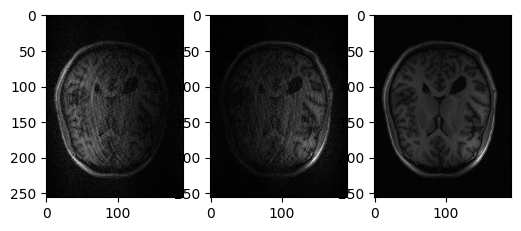

In [14]:

indx=30
Y_rss=np.sqrt(np.sum(np.square(Y_train_arr),axis=1))
fix, ax=plt.subplots(nrows=1,ncols=3,figsize=(6,8))
ax[0].imshow(X_train_arr[indx,0,:,:],cmap='gray')
ax[1].imshow(X_train_arr[indx,1,:,:],cmap='gray')
ax[2].imshow(Y_rss[indx,:,:],cmap='gray')

#### Save the data for future use

In [7]:
save_data="/research/sharedresources/cbi/data_exchange/huagrp/Shahinur/tmp/"
np.save(save_data+"2d_trainig.npy",X_train_arr)
np.save(save_data+"2d_trainig_GT.npy",Y_train_arr)

### 3. Perform Data augmentation

In [9]:
import imageio
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import skimage.io as io
from medpy.io import load,save
import numpy, imageio
import glob, os
import shutil
import itertools
import random
import scipy.ndimage as ndimage
from skimage.measure import label,regionprops
import random

seq = iaa.Sequential([
    iaa.Fliplr(1), # horizontally flip 50% of all images
    iaa.Flipud(1), # vertically flip 20% of all images
    iaa.Dropout([0.1, 0.2]),      # drop 5% or 20% of all pixels
    iaa.GaussianBlur(sigma=(1.5)),
    iaa.GaussianBlur(sigma=(0.8)),
    iaa.GaussianBlur(sigma=(3)),
    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.4, 3.5)),

    #PiecewiseAffine and elastic deformation
    iaa.PiecewiseAffine(scale=(0.01, 0.03)),
    iaa.PiecewiseAffine(scale=(0.04, 0.06)),
    iaa.ElasticTransformation(alpha=(2.0,4.0), sigma=1),
    iaa.ElasticTransformation(alpha=(14.0,17.0), sigma=5),  # 
    iaa.Affine(rotate=(-20, -15),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale={"x": (0.8), "y": (0.8)}, order=3,
            ),
    

    iaa.Affine(rotate=(-10, -5),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale={"x": (1.1), "y": (1.1)}, order=3,
            ),
    iaa.Affine(rotate=(5, 10),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale={"x": (0.8), "y": (0.8)}, order=3,
            ),
    

    iaa.Affine(rotate=(15, 20),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            scale={"x": (1.1), "y": (1.1)}, order=3,
            )
              
], random_order=False)


            
def apply_augmentation(seq_picked,image,ref):
    """ apply augmentation on each image and mask
    """
    augseq_det = seq_picked.to_deterministic()
    dist_image=augseq_det.augment_image(image)
    ref_image=augseq_det.augment_image(ref)

    return dist_image, ref_image


augmented_image_X=[]
augmented_image_Y=[]

X_train_arr=np.transpose(X_train_arr,(0,2,3,1))
Y_train_arr=np.transpose(Y_train_arr,(0,2,3,1))
print(X_train_arr.shape,Y_train_arr.shape)

#print(X_train_arr.shape)
#read all files and apply augmentation
for k in range(X_train_arr.shape[0]):
    image=X_train_arr[k,:,:,:].astype(np.float32)
    ref=Y_train_arr[k,:,:,:].astype(np.float32)
    #image=np.transpose(image,(1,2,0))
    #ref=np.transpose(ref,(1,2,0))
    augmented_image_X.append(image)
    augmented_image_Y.append(ref)
    for i in range(len(seq)):
        
        seq_picked=iaa.Sequential([seq[i]])
        dist_image, ref_image=apply_augmentation(seq_picked,image,ref)
        augmented_image_X.append(dist_image)
        if i in [2,3,4,5,6]:
            augmented_image_Y.append(ref)
        else:
            augmented_image_Y.append(ref_image)
        if dist_image.shape[0]!=224 and dist_image.shape[1]!=192 and dist_image.shape[1]!=12:
            print(image.shape,dist_image.shape,ref_image.shape)
    
    #PiecewiseAffine and Affine
    seq_picked=iaa.Sequential([seq[7],seq[11]])
    dist_image, ref_image=apply_augmentation(seq_picked,image,ref)
    augmented_image_X.append(dist_image)
    augmented_image_Y.append(ref_image)
    
    #Elastic and Affine
    seq_picked=iaa.Sequential([seq[10],seq[11]])
    dist_image, ref_image=apply_augmentation(seq_picked,image,ref)
    augmented_image_X.append(dist_image)
    augmented_image_Y.append(ref_image)
    
    seq_picked=iaa.Sequential([seq[9],seq[14]])
    dist_image, ref_image=apply_augmentation(seq_picked,image,ref)
    augmented_image_X.append(dist_image)
    augmented_image_Y.append(ref_image)

X_train_arr=np.array(augmented_image_X)
Y_train_arr=np.array(augmented_image_Y)
#Y_rss=np.sqrt(np.sum(np.square(Y_train_arr),axis=3))
print(X_train_arr.shape,Y_train_arr.shape)   
    
    

In [14]:
save_data="/research/sharedresources/cbi/data_exchange/huagrp/Shahinur/tmp/"
np.save(save_data+"2d_trainig_grappa_augmented.npy",X_train_arr)
np.save(save_data+"2d_trainig_GT_grappa_augmented.npy",Y_train_arr)


#### Normalize the data

In [27]:
Y_rss=np.sqrt(np.sum(np.square(Y_train_arr),axis=3))
Y_rss=Y_rss.astype(np.float32)
#X_train_arr=X_train_arr.astype(np.float32)
dims=X_train_arr.shape
print(dims)
for i in range(dims[0]):
    for j in range(dims[3]):
        X_train_arr[i,:,:,j]=X_train_arr[i,:,:,j]/((np.max(X_train_arr[i,:,:,j])-np.min(X_train_arr[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_rss[i,:,:]=Y_rss[i,:,:]/((np.max(Y_rss[i,:,:])-np.min(Y_rss[i,:,:]))+1e-10)

(4492, 12, 224, 192)


#### Split the training and validation set

In [6]:

Y_rss=Y_rss.reshape((85348, 224, 192,1))
x_train=X_train_arr[15102:,:,:,:]
x_test=X_train_arr[0:15102,:,:,:]
y_train=Y_rss[15102:,:,:,:]
y_test=Y_rss[0:15102,:,:,:]

In [8]:
import gc
gc.collect()
del X_train_arr
del Y_train_arr
del Y_rss
del X_train_arr_new

### 4. Build Model

In [168]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,BatchNormalization, Activation,Conv2D,ZeroPadding2D,MaxPooling2D,Reshape, AveragePooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU,add, Attention, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG19
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import tensorflow_addons as tfa
from tensorflow.keras.applications.vgg19 import preprocess_input

model=None
kernel_size=(3,3)
loss_weights=[1.0,0.0001,0.000001,0]


selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01 , 2 , 4 ]
selected_layer_weights_style = [0.1, 1 , 1 , 2 ]

#selected_layers = ['block5_conv4']
#selected_layer_weights = [1.0]


vgg = VGG19(weights='imagenet', include_top=False, input_shape=(224,192,3))
vgg.trainable = False
#outputs_names = [ layer_l.name for layer_l in vgg.layers]
#print(outputs_names)
outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable=False


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


def vgg_RSS(tensor):
    Y_rss=tf.math.sqrt(tf.math.reduce_sum(tf.square(tensor),axis=-1))
    return Y_rss

def compute_loss(A, B):
    meanA = tf.reduce_mean(A, axis=(1,2), keepdims=True)
    meanB = tf.reduce_mean(B, axis=(1,2), keepdims=True)
    nA = tf.sqrt(tf.reduce_sum(tf.square(A), axis=(1,2), keepdims=True))
    nB = tf.sqrt(tf.reduce_sum(tf.square(B), axis=(1,2), keepdims=True))
    return 1-(tf.reduce_sum((A-meanA)/nA*(B-meanB)/nB))

def model_loss_all(y_true, y_pred):
    global vgg_model
    
    ssim_loss=1- tf.math.abs(tf.reduce_mean(tf.image.ssim(img1=y_true, img2=y_pred,max_val=1.0,filter_size=3,filter_sigma=0.1)))
    pixel_loss=tf.reduce_mean(tf.math.abs(y_true-y_pred))
    
    content_loss =0.0
    style_loss = 0.0
    batch_size=y_true.shape[0]
    res_y_rss=tf.image.grayscale_to_rgb(y_true*255)
    res_y_rss=preprocess_input(res_y_rss)
    vgg_f_gt=vgg_model(res_y_rss)

    res_y_pred=tf.image.grayscale_to_rgb(y_pred*255)
    res_y_pred=preprocess_input(res_y_pred)
    vgg_f_pred=vgg_model( res_y_pred)

    #print("here:",vgg_f_gt.get_shape(),vgg_f_pred.get_shape())
    for h1, h2, cw,sw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content, selected_layer_weights_style):
 
        content_loss = content_loss +cw *tf.reduce_mean(tf.square(tf.math.abs(h1 - h2)))
        #y_gram=gram_matrix(h1)
        #pred_gram=gram_matrix(h2)
        #style_loss = style_loss + sw *tf.reduce_mean(tf.square(abs(y_gram - pred_gram)))
    #print(content_loss,style_loss)
    #print(loss_weights[0]*ssim_loss,loss_weights[1]*pixel_loss,loss_weights[2]*content_loss,loss_weights[3]*style_loss)
    
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*pixel_loss +loss_weights[2]*content_loss #+loss_weights[3]*style_loss
    
def model_loss_NMSE(y_true, y_pred):
    nmse=tf.sqrt(y_pred-y_true)/(tf.sqrt(y_true)+1e-8)
    return nmse
    #return 1- tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
def conv_block(ip, nfilters,drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top =BatchNormalization()(layer_top)

    res_model=PReLU()(layer_top)
    res_model=Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model =BatchNormalization()(res_model)

    res_model=Dropout(drop_rate)(res_model)
    res_model=add([layer_top,res_model])
    res_model=PReLU()(res_model)
    return res_model

def encoder(inp,nlayers, nbasefilters, drop_rate):
    
    skip_layers=[]
    layers=inp
    for i in range(nlayers):
        layers=conv_block(layers,nbasefilters*2**i,drop_rate)
        
        #attention
        #layers=Attention()([layers,layers])
        
        skip_layers.append(layers)
        layers=MaxPooling2D((2,2))(layers)
    
    return layers, skip_layers


def decoder(inp,nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers=inp
    for i in range(nlayers):
        layers=conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        
        #attention
        #layers=Attention()([layers,layers])
        #mul_layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1,2, 3))
        #layers=mul_layer(layers, layers)
        
        
        #layers=UpSampling2D((2,2))(layers)
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers


def create_gen(gen_ip, nlayers,nbasefilters,lambda_l, drop_rate):
    op, skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op=decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape=(shape[0],shape[1],channel)
input_layer=Input(shape=input_shape)
model=create_gen(input_layer,5,32,1,0.01)

### 5. Train model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
model_name="weights/model_deepmrirec.h5"
def step_decay(epoch, initial_lrate, drop, epochs_drop):
    return initial_lrate * math.pow(drop, math.floor((1+epoch)/float(epochs_drop)))


def get_callbacks(model_file, learning_rate_drop=0.7,learning_rate_patience=7, verbosity=1):
    callbacks = list()
    callbacks.append(ModelCheckpoint(model_file, save_best_only=True))
    callbacks.append(ReduceLROnPlateau(factor=learning_rate_drop, patience=learning_rate_patience,verbose=verbosity))
    callbacks.append(EarlyStopping(verbose=verbosity, patience=30))
    return callbacks
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model=create_gen(input_layer,5,32,1,0.01)
    metrics=tf.keras.metrics.RootMeanSquaredError()
    model.compile(loss=model_loss_all, optimizer= Adam(learning_rate=0.0001),metrics=[metrics] )
    history=model.fit(x_train, y_train,
                    epochs=700,
                    batch_size=4*128,
                    shuffle=True,
                    validation_data=(x_test, y_test),
                    callbacks=get_callbacks(model_name,0.6,10,1)
                     )

model_json = model.to_json()
with open("weights/model32d.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights/model32d.h5")
print("Saved model to disk")



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

138/138 [==============================] - 114s 827ms/step - root_mean_squared_error: 0.0415 - loss: 0.1637 - val_root_mean_squared_error: 0.0436 - val_loss: 0.1597 - lr: 1.0000e-04
Epoch 52/700
138/138 [==============================] - 113s 816ms/step - root_mean_squared_error: 0.0407 - loss: 0.1574 - val_root_mean_squared_error: 0.0433 - val_loss: 0.1592 - lr: 1.0000e-04
Epoch 53/700
138/138 [==============================] - 113s 821ms/step - root_mean_squared_error: 0.0401 - loss: 0.1521 - val_root_mean_squared_error: 0.0443 - val_loss: 0.1545 - lr: 1.0000e-04
Epoch 54/700
138/138 [==============================] - 112s 809ms/step - root_mean_squared_error: 0.0396 - loss: 0.1492 - val_root_mean_squared_error: 0.0423 - val_loss: 0.1506 - lr: 1.0000e-04
Epoch 55/700
138/138 [==============================] - 112s 811ms/step - root_mean_squared_error: 0.0392 - loss: 0.1444 - val_root_mean_squared_error: 0.0455 - val_loss: 0.1628 - lr: 1.0000e-04
Epoch 56/700
138/138 [================

138/138 [==============================] - 107s 773ms/step - root_mean_squared_error: 0.0292 - loss: 0.0712 - val_root_mean_squared_error: 0.0377 - val_loss: 0.1066 - lr: 3.6000e-05
Epoch 134/700
138/138 [==============================] - 102s 739ms/step - root_mean_squared_error: 0.0292 - loss: 0.0711 - val_root_mean_squared_error: 0.0374 - val_loss: 0.1068 - lr: 3.6000e-05
Epoch 135/700
138/138 [==============================] - 109s 791ms/step - root_mean_squared_error: 0.0292 - loss: 0.0708 - val_root_mean_squared_error: 0.0377 - val_loss: 0.1076 - lr: 3.6000e-05
Epoch 136/700
138/138 [==============================] - 109s 786ms/step - root_mean_squared_error: 0.0292 - loss: 0.0708 - val_root_mean_squared_error: 0.0374 - val_loss: 0.1077 - lr: 3.6000e-05
Epoch 137/700
138/138 [==============================] - 105s 760ms/step - root_mean_squared_error: 0.0292 - loss: 0.0707 - val_root_mean_squared_error: 0.0375 - val_loss: 0.1080 - lr: 3.6000e-05
Epoch 138/700
138/138 [===========

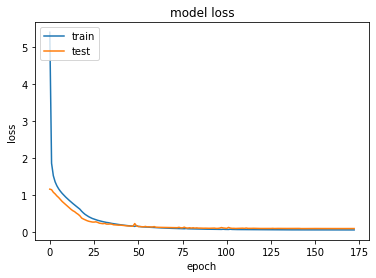

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 6. Load TEST data and Evaluate model

In [149]:
from tensorflow.keras.models import load_model
#load best weights
path="/research/sharedresources/cbi/data_exchange/huagrp/Shahinur/model/weights/"
model.load_weights(path+"weights/model_deepmrirec.h5")


In [158]:
ex_recons_imgs = model.predict(x_test)

29/29 [==============================] - 1s 21ms/step


#### Visualize reconstruction outcome 

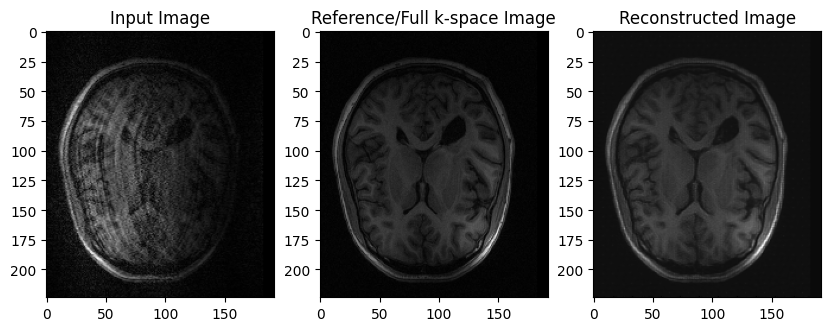

In [154]:
indx=30
fix, ax=plt.subplots(nrows=1,ncols=3,figsize=(10,8))
ax[0].imshow(x_test[indx,:,:,0],cmap='gray')
ax[1].imshow(y_test[indx,:,:],cmap='gray')
ax[2].imshow(ex_recons_imgs[indx,:,:],cmap='gray')

ax[0].title.set_text('Input Image')
ax[1].title.set_text('Reference/Full k-space Image')
ax[2].title.set_text('Reconstructed Image')
plt.show()

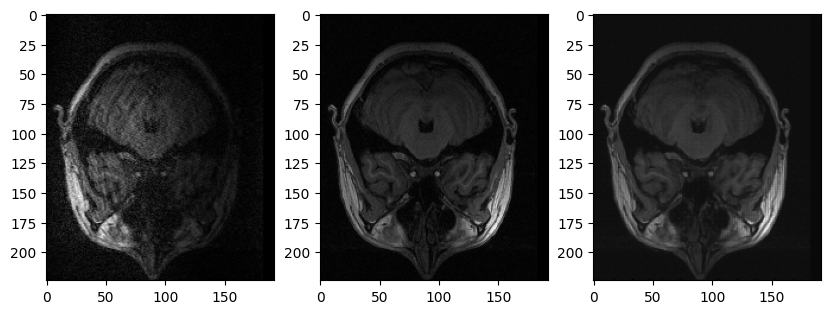

In [155]:
indx=10
fix, ax=plt.subplots(nrows=1,ncols=3,figsize=(10,8))
ax[0].imshow(x_test[indx,:,:,0],cmap='gray')
ax[1].imshow(y_test[indx,:,:],cmap='gray')
ax[2].imshow(ex_recons_imgs[indx,:,:],cmap='gray')
plt.show()